# Example - Credit Risk

<h1>Index<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling" data-toc-modified-id="Modeling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data</a></span></li></ul></li><li><span><a href="#Checking-the-support-in-the-different-environments" data-toc-modified-id="Checking-the-support-in-the-different-environments-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Checking the support in the different environments</a></span><ul class="toc-item"><li><span><a href="#Benchmark" data-toc-modified-id="Benchmark-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Benchmark</a></span></li></ul></li><li><span><a href="#Challenger-model" data-toc-modified-id="Challenger-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Challenger model</a></span></li><li><span><a href="#Feature-Importance-migration" data-toc-modified-id="Feature-Importance-migration-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Importance migration</a></span></li><li><span><a href="#Reverse-Learning-Curve" data-toc-modified-id="Reverse-Learning-Curve-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Reverse Learning Curve</a></span></li><li><span><a href="#Performance-comparison" data-toc-modified-id="Performance-comparison-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Performance comparison</a></span></li><li><span><a href="#TRF-as-feature-selection" data-toc-modified-id="TRF-as-feature-selection-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>TRF as feature selection</a></span></li><li><span><a href="#Feature-Impact" data-toc-modified-id="Feature-Impact-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Feature Impact</a></span></li><li><span><a href="#Minimum-samples-by-period-effect" data-toc-modified-id="Minimum-samples-by-period-effect-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Minimum samples by period effect</a></span></li><li><span><a href="#Domain-classifier" data-toc-modified-id="Domain-classifier-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Domain classifier</a></span></li><li><span><a href="#Other-optimization-design-for-the-RF" data-toc-modified-id="Other-optimization-design-for-the-RF-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Other optimization design for the RF</a></span></li></ul></div>

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from time_robust_forest.models import TimeForestClassifier
from time_robust_forest.functions import check_categoricals_match, check_numerical_match
from time_robust_forest.hyper_opt import env_wise_hyper_opt
from aux_functions import *

np.random.seed(42)

In [97]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    plt.rcParams['figure.figsize'] = (12, 4)

In [98]:
set_style()

In [99]:
DATASETS_PATH = "~/Documents/datasets/credit_risk/"
PREFIX = "credit_risk"

In [100]:
data = pd.read_csv(DATASETS_PATH + "loan.csv", error_bad_lines=False)

In [101]:
data.shape

(887379, 74)

In [102]:
#data = data.sample(frac=0.5)

In [103]:
data.shape

(887379, 74)

In [104]:
data.nunique()

id                  887379
member_id           887379
loan_amnt             1372
funded_amnt           1372
funded_amnt_inv       9856
                     ...  
all_util              1128
total_rev_hi_lim     21251
inq_fi                  18
total_cu_tl             33
inq_last_12m            29
Length: 74, dtype: int64

In [105]:
data.dtypes

id                    int64
member_id             int64
loan_amnt           float64
funded_amnt         float64
funded_amnt_inv     float64
                     ...   
all_util            float64
total_rev_hi_lim    float64
inq_fi              float64
total_cu_tl         float64
inq_last_12m        float64
Length: 74, dtype: object

In [106]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
data["loan_status"].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

In [108]:
data["loan_status"].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [109]:
non_default_status = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']

loan_status_of_interest = ['Fully Paid', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)', 'Default',
                           'Does not meet the credit policy. Status:Fully Paid', 
                           'Does not meet the credit policy. Status:Charged Off']

data = data[data["loan_status"].isin(loan_status_of_interest)]
data["default"] = data["loan_status"].apply(lambda x: 0 if x in non_default_status else 1)

In [110]:
data["Year"] = data["issue_d"].apply(lambda x: int(x.split("-")[-1]))

In [111]:
print(data["default"].mean())
data["default"].value_counts()

0.22583586513933854


0    209711
1     61176
Name: default, dtype: int64

In [112]:
data["Year"].value_counts()

2014    75012
2013    73514
2012    49840
2015    31974
2011    19740
2010    12530
2009     5281
2008     2393
2007      603
Name: Year, dtype: int64

In [113]:
data["Year"] = data["Year"].apply(lambda x: 2010 if x in [2010, 2009, 2008, 2007] else x)

In [114]:
data["Year"].value_counts()

2014    75012
2013    73514
2012    49840
2015    31974
2010    20807
2011    19740
Name: Year, dtype: int64

In [115]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default,Year
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2011
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2011
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2011
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2011
5,1075269,1311441,5000.0,5000.0,5000.0,36 months,7.90,156.46,A,A4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2011


In [116]:
data.select_dtypes(exclude=['int64', 'float32', 'float64']).columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type',
       'verification_status_joint'],
      dtype='object')

In [117]:
data.select_dtypes(exclude=['object']).columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'default',
       'Year'],
      dtype='object')

## Modeling

### Data

In [118]:
TIME_COLUMN = "Year"
TARGET = "default"

In [119]:
columns_to_label_encode = ["term", 
                           "grade",
                           "sub_grade",
                           "emp_length",
                           "home_ownership",
                           "verification_status",
                           "purpose",
                           "addr_state",
                           "initial_list_status"]


columns_to_label_encode  = ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type',
       'verification_status_joint']

In [120]:
encoder_mappings = {}
le = LabelEncoder()
for column in columns_to_label_encode:
    print(column)
    data[column].fillna("None", inplace=True)
    data[column] = le.fit_transform(data[[column]])
    encoder_mappings[column] = {i: le.__dict__["classes_"][i] for i in range(len(le.__dict__["classes_"]))}

term
grade
sub_grade
emp_title
emp_length
home_ownership
verification_status
pymnt_plan
url
desc
purpose
title
zip_code
addr_state
earliest_cr_line
initial_list_status
last_pymnt_d
next_pymnt_d
last_credit_pull_d
application_type
verification_status_joint


In [232]:
numerical_features = ["loan_amnt", 
                      "funded_amnt", 
                      "funded_amnt_inv",
                      "annual_inc",
                      "dti",
                      "delinq_2yrs",
                      "inq_last_6mths",
                      "open_acc",
                      "pub_rec",
                      "revol_bal",
                      "revol_util",
                      "total_acc"]



numerical_features = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'int_rate', 'installment', 'dti', 'annual_inc', 
    'mths_since_last_delinq', 'mths_since_last_record', 'delinq_2yrs',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc']



In [233]:
data[numerical_features+[TARGET]].corr()["default"]

loan_amnt                 0.073622
funded_amnt               0.073970
funded_amnt_inv           0.072342
int_rate                  0.256305
installment               0.057041
dti                       0.136320
annual_inc               -0.055311
mths_since_last_delinq   -0.033418
mths_since_last_record    0.012379
delinq_2yrs               0.034833
open_acc                  0.024670
pub_rec                   0.019051
revol_bal                -0.001594
revol_util                0.100644
total_acc                -0.027065
default                   1.000000
Name: default, dtype: float64

In [234]:
numerical_features

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'int_rate',
 'installment',
 'dti',
 'annual_inc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'delinq_2yrs',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc']

In [235]:
data[numerical_features] = data[numerical_features].astype(float)

In [254]:
features = numerical_features + columns_to_label_encode

In [255]:
data["Year"].value_counts()

2014    75012
2013    73514
2012    49840
2015    31974
2010    20807
2011    19740
Name: Year, dtype: int64

In [272]:
data.groupby("Year")["default"].mean()

Year
2010    0.150815
2011    0.165653
2012    0.167757
2013    0.232854
2014    0.270610
2015    0.281166
Name: default, dtype: float64

In [256]:
training_end_year = 2012
holdout_end_year = 2014

In [257]:
in_time = data[data["Year"] <= training_end_year]
out_of_time = data[data["Year"] > training_end_year]

In [258]:
train, test = train_test_split(in_time, 
                               test_size=0.2,
                               random_state=42)

In [259]:
train["Year"].value_counts()

2012    39924
2010    16547
2011    15838
Name: Year, dtype: int64

In [260]:
train.shape

(72309, 76)

In [261]:
test.shape

(18078, 76)

In [262]:
out_of_time.shape

(180500, 76)

In [263]:
median_input = train.median()
train.fillna(median_input, inplace=True)
test.fillna(median_input, inplace=True)
out_of_time.fillna(median_input, inplace=True)

## Checking the support in the different environments

In [264]:
# check_categoricals_match(train, columns_to_label_encode, "Year")

In [265]:
# check_numerical_match(train, numerical_features, TIME_COLUMN, verbose=True, n_q=3)

### Benchmark

In [266]:
from pycaret.classification import *

In [267]:
TARGET

'default'

In [268]:
clf1 = setup(train[features + [TARGET]], 
             target=TARGET,
             session_id=1332, 
             log_experiment=False, 
             experiment_name="{}".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=2,
                     n_iter=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6587,0.7026,0.6155,0.2633,0.3688,0.1835,0.2146
1,0.6430,0.7158,0.6793,0.2651,0.3814,0.1934,0.2357
Mean,0.6508,0.7092,0.6474,0.2642,0.3751,0.1884,0.2252
SD,0.0079,0.0066,0.0319,0.0009,0.0063,0.0049,0.0105


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 3
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0002, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=230,
                       n_jobs=-1, oob_score=False, random_state=1332, verbose=0,
                       warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [269]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0002, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=230,
                       n_jobs=-1, oob_score=False, random_state=1332, verbose=0,
                       warm_start=False)

In [270]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_sklearn"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [271]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_sklearn"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_sklearn"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_sklearn"]))

0.7204346199052941
0.7159890173603658
0.7361555522091917


In [57]:
params_grid = {"n_estimators": [100], 
              "max_depth": [12],
              "min_impurity_decrease": [1e-5, 0],
              "min_sample_periods": [1, 5],
              "period_criterion": ["max", "avg"]}

params_grid_benchmark = params_grid.copy()
params_grid_benchmark.pop("period_criterion")
# params_grid = {"n_estimators": [5], 
#               "max_depth": [5],
#               "min_impurity_decrease": [0.001],
#               "min_sample_periods": [5]}

['max', 'avg']

In [58]:
params_grid

{'n_estimators': [100],
 'max_depth': [12],
 'min_impurity_decrease': [1e-05, 0],
 'min_sample_periods': [1, 5],
 'period_criterion': ['max', 'avg']}

In [59]:
params_grid_benchmark

{'n_estimators': [100],
 'max_depth': [12],
 'min_impurity_decrease': [1e-05, 0],
 'min_sample_periods': [1, 5]}

In [60]:
DUMMY_TIME_COLUMN = "dummy_time_column"
train[DUMMY_TIME_COLUMN] = 1

In [61]:
# model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
#                                         multi=True)

# benchmark_opt_param = env_wise_hyper_opt(train[features + [DUMMY_TIME_COLUMN]], train[TARGET], 
#                                          model, 
#                                          DUMMY_TIME_COLUMN, 
#                                          params_grid_benchmark, 
#                                          cv=5,
#                                          scorer=make_scorer(roc_auc_score,
#                                                             needs_proba=True),
#                                         n_jobs=24)

benchmark_opt_param = {'max_depth': 12,
 'min_impurity_decrease': 0,
 'min_sample_periods': 1,
 'n_estimators': 100}

In [62]:
benchmark_opt_param

{'max_depth': 12,
 'min_impurity_decrease': 0,
 'min_sample_periods': 1,
 'n_estimators': 100}

In [63]:
benchmark_model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
                                       multi=True, 
                                       **benchmark_opt_param)

In [64]:
benchmark_model.fit(train[features + [DUMMY_TIME_COLUMN]], train[TARGET].values)

In [65]:
train["benchmark_prediction"] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction"] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction"] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 567, in run
    self.flag_executor_shutting_down()
  File "/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 756, in flag_executor_shutting_down
    self.kill_workers()
  File "/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py", line 766, in kill_workers
    recursive_terminate(p)
  File "/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/site-packages/joblib/externals/loky/backend/utils.py", line 28, in recursive_terminate
    _recursive_terminate_without_psutil(process)
  File "/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/s

Traceback (most recent call last):
  File "/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/site-packages/joblib/parallel.py", line 933, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/site-packages/joblib/_parallel_backends.py", line 542, in wrap_future_result
    return future.result(timeout=timeout)
  File "/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/concurrent/futures/_base.py", line 427, in result
    self._condition.wait(timeout)
  File "/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/threading.py", line 295, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/site-packages/joblib/parallel.py", line 1054, in __call__
    self.retrieve()
  File "/Users/luis.moneda/opt/miniconda3/envs/ml3/lib/python3.6/site-

TypeError: object of type 'NoneType' has no len()

In [ ]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction"]))

In [ ]:
results = reverse_learning_curve(train, 
                                 out_of_time, 
                                 benchmark_model, 
                                 features, 
                                 TARGET,
                                 TIME_COLUMN, 
                                 roc_auc_score, 
                                 n_rounds=5,
                                 dummy_time_column=DUMMY_TIME_COLUMN)

In [ ]:
benchmark_importances = results["feature_importance"][-1].copy(deep=True)
benchmark_importances.rename("RF", inplace=True)

In [ ]:
importance_by_reverse_segment_benchmark = plot_feature_migration_from_learning_curve_results(results, 
                                                                                             features, 
                                                                                             save_as="../images/{}_benchmark_importance_migration_learning_curve.eps".format(PREFIX))

In [ ]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
gradient = np.linspace(.2, 0.8, len(results["holdout_performance"]))

for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [ ]:
results

## Challenger model

In [ ]:
train.reset_index(drop=True, inplace=True)

In [ ]:
train[features + [TIME_COLUMN]]

In [ ]:
train["Year"].value_counts()

In [ ]:
# model = TimeForestClassifier(time_column=TIME_COLUMN,
#                                         multi=True)

# challenger_opt_param = env_wise_hyper_opt(train[features + [TIME_COLUMN]], 
#                                           train[TARGET], 
#                                           model, 
#                                           TIME_COLUMN,
#                                           params_grid,
#                                           scorer=make_scorer(roc_auc_score,
#                                                             needs_proba=True),
#                                          n_jobs=-1)

challenger_opt_param = {'max_depth': 10,
 'min_impurity_decrease': 0,
 'min_sample_periods': 10,
 'n_estimators': 30,
 'period_criterion': 'max'}

In [ ]:
challenger_opt_param

In [ ]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        multi=True,
                                        **challenger_opt_param)

challenger_model.fit(train[features + [TIME_COLUMN]], train[TARGET].values)

train["challenger_prediction"] = challenger_model.predict_proba(train[features])[:, 1]
test["challenger_prediction"] = challenger_model.predict_proba(test[features])[:, 1]
out_of_time["challenger_prediction"] = challenger_model.predict_proba(out_of_time[features])[:, 1]

In [ ]:
print(roc_auc_score(train[TARGET], train["challenger_prediction"]))
print(roc_auc_score(test[TARGET], test["challenger_prediction"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["challenger_prediction"]))

## Feature Importance migration

In [ ]:
challenger_model = TimeForestClassifier(time_column=TIME_COLUMN,
                                        multi=True,
                                        **challenger_opt_param)

results_trt = reverse_learning_curve(train, 
                                     out_of_time, 
                                     challenger_model, 
                                     features, TARGET, TIME_COLUMN, roc_auc_score, n_rounds=5, challenger=True)

In [ ]:
challenger_model_importances = results_trt["feature_importance"][-1].copy(deep=True)
challenger_model_importances.rename("TRF", inplace=True)
challenger_model_importances

In [ ]:
all_models_importance = pd.DataFrame(index=features)
all_models_importance = all_models_importance.merge(benchmark_importances, how="left", left_index=True, 
                            right_index=True)
all_models_importance = all_models_importance.merge(challenger_model_importances, how="left", left_index=True, 
                            right_index=True)

all_models_importance.fillna(0, inplace=True)
all_models_importance

In [ ]:
plot_shap_difference(all_models_importance[["RF", "TRF"]], title="", save_as="../images/{}_importance_migration.eps".format(PREFIX))

In [72]:
results_trt

{'round': [],
 'holdout_performance': [0.8965407410137989,
  0.9020645293871727,
  0.9029071138688081,
  0.9034606384915568,
  0.9036572687032016,
  0.9038014475457435,
  0.9035127831349188,
  0.9033105963710146,
  0.9031817588853491,
  0.9016160798774262],
 'feature_importance': [Primary Type            0.074905
  Description             0.076006
  Location Description    0.018925
  FBI Code                0.100385
  Zone                    0.000181
  Address                -0.000080
  Latitude               -0.002118
  Longitude               0.002169
  Beat                    0.000630
  District                0.001362
  Ward                   -0.000531
  Community Area          0.001948
  Domestic                0.005358
  Name: 2010, dtype: float64,
  Primary Type            0.077501
  Description             0.078464
  Location Description    0.011060
  FBI Code                0.107136
  Zone                    0.000260
  Address                -0.001081
  Latitude               

## Reverse Learning Curve

In [ ]:
importance_by_reverse_segment_challenger = plot_feature_migration_from_learning_curve_results(results_trt, features, 
                                                                                             save_as="../images/{}_challenger_importance_migration_learning_curve.eps".format(PREFIX))
importance_by_reverse_segment_challenger

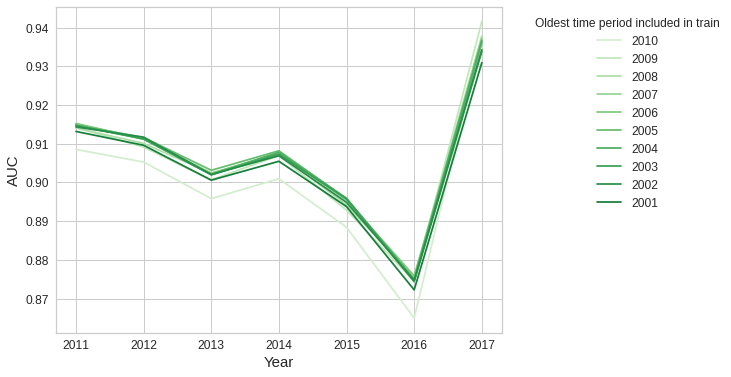

In [73]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

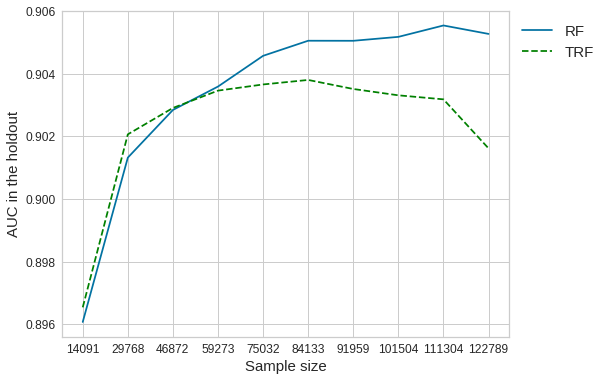

In [74]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["sample_size"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Sample size", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_sample.eps".format(PREFIX), format="eps")
plt.show()

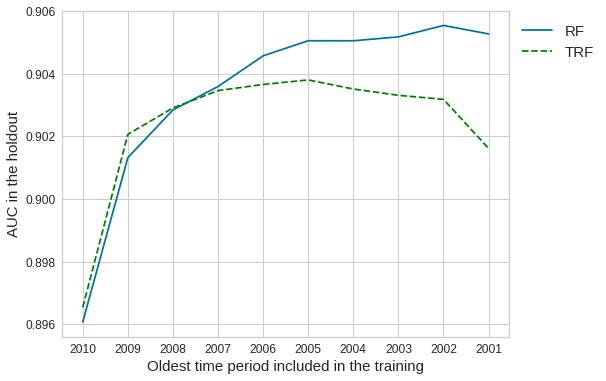

In [75]:
fig, ax = plt.subplots()
plt.plot([str(i) for i in results["last_period_included"]], results["holdout_performance"], label="RF")
plt.plot(results_trt["holdout_performance"], label="TRF", linestyle="dashed", color="green")
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC in the holdout", fontsize=15)
plt.xlabel("Oldest time period included in the training", fontsize=15)
plt.savefig("../images/{}_reverse_learning_curve_segments.eps".format(PREFIX), format="eps")
plt.show()

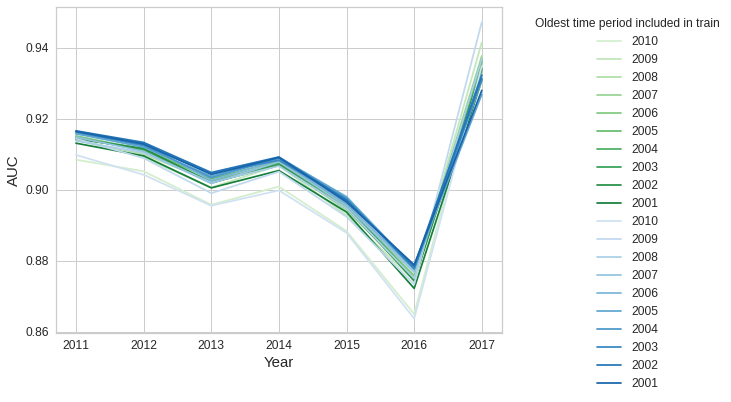

In [76]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.2, 0.8, len(results_trt["holdout_performance"]))

for i, r in enumerate(results_trt["holdout_performance_by_period"]):
    r.plot(label=results_trt["last_period_included"][i], color=greens(gradient[i]))
    
for i, r in enumerate(results["holdout_performance_by_period"]):
    r.plot(label=results["last_period_included"][i], color=blues(gradient[i]))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Oldest time period included in train")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

plt.savefig("../images/{}_perf_by_period_reverse_learning_curve_both.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

## Performance comparison

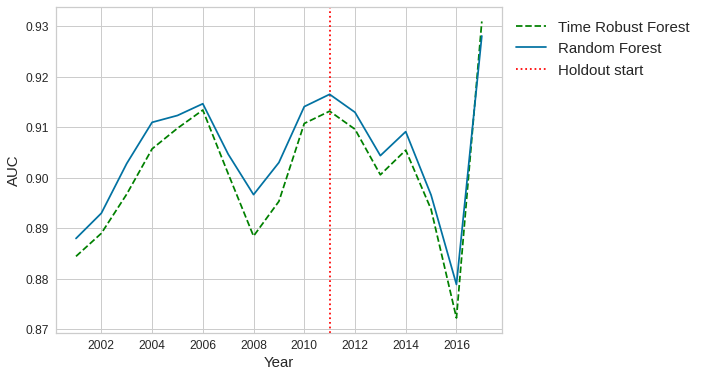

In [77]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_test_holdout_auc_years.eps".format(PREFIX), format="eps")
plt.show()

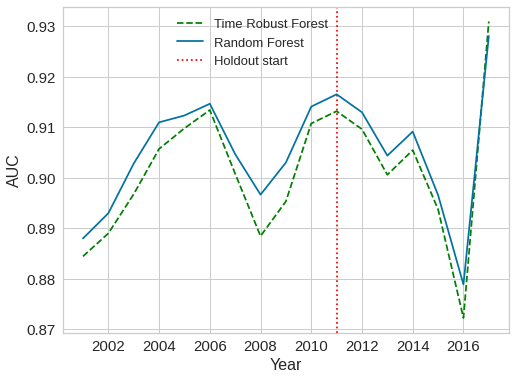

In [78]:
plt.rcParams['figure.figsize'] = (8, 6)
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=13, 
           bbox_to_anchor=(0.62, 1.0))

plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square.eps".format(PREFIX), format="eps")
plt.show()

## TRF as feature selection

In [80]:
challenger_model.feature_importance()

,Importance
Feature,
Latitude,6284
Longitude,6147
Address,5630
Beat,5579
Description,4751
Location Description,4736
District,3091
Primary Type,2859
FBI Code,2633


In [82]:
selected_features = [feature for feature in features if feature in challenger_model.feature_importance(impurity_decrease=True).index]
selected_features

['Primary Type',
 'Description',
 'Location Description',
 'FBI Code',
 'Zone',
 'Address',
 'Latitude',
 'Longitude',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'Domestic']

In [84]:
if len(selected_features) == len(features):
    selected_features = list(challenger_model.feature_importance().sort_values(by="Importance", ascending=False).index[:int(len(features)/2)+2].values)
    
selected_features    

['Latitude',
 'Longitude',
 'Address',
 'Beat',
 'Description',
 'Location Description',
 'District',
 'Primary Type']

In [85]:
selected_features

['Latitude',
 'Longitude',
 'Address',
 'Beat',
 'Description',
 'Location Description',
 'District',
 'Primary Type']

In [86]:
clf1 = setup(train[selected_features + [TARGET]], 
             target=TARGET,
             session_id=3, 
             log_experiment=False, 
             experiment_name="{}_fs".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     fold=5,
                     n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8705,0.9043,0.7001,0.8271,0.7584,0.6708,0.6751
1,0.8719,0.9044,0.7185,0.8177,0.7649,0.6773,0.6800
2,0.8693,0.9028,0.7053,0.8193,0.7580,0.6692,0.6727
3,0.8686,0.9021,0.7057,0.8167,0.7572,0.6678,0.6711
4,0.8736,0.9055,0.7115,0.8288,0.7657,0.6799,0.6836
Mean,0.8708,0.9038,0.7082,0.8219,0.7608,0.6730,0.6765
SD,0.0018,0.0012,0.0063,0.0050,0.0037,0.0047,0.0046


In [87]:
tuned_rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=260, n_jobs=-1, oob_score=False,
                       random_state=3, verbose=0, warm_start=False)

In [88]:
benchmark_model = tuned_rf
benchmark_model.fit(train[selected_features], train[TARGET])

train["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(train[selected_features])[:, 1]
test["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(test[selected_features])[:, 1]
out_of_time["benchmark_prediction_opt_selected_features"] = benchmark_model.predict_proba(out_of_time[selected_features])[:, 1]

In [89]:
print(roc_auc_score(train[TARGET], train["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(test[TARGET], test["benchmark_prediction_opt_selected_features"]))
print(roc_auc_score(out_of_time[TARGET], out_of_time["benchmark_prediction_opt_selected_features"]))

0.9191605803453263
0.9034568399777978
0.9036398651860773


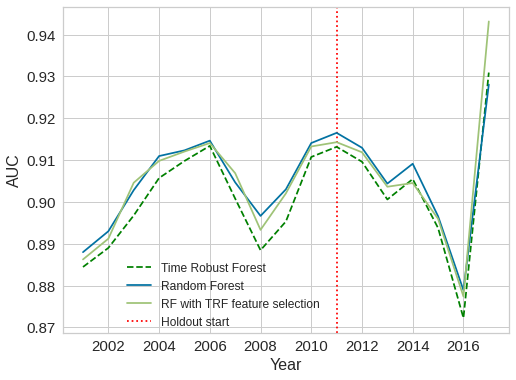

In [90]:
fig, ax = plt.subplots(figsize=(8, 6))
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="Random Forest", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_selected_features"])).plot(label="RF with TRF feature selection", ax=ax)


ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=12, bbox_to_anchor=(0.12, 0.25))
plt.ylabel("AUC", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.savefig("../images/{}_test_holdout_auc_years_square_fs.eps".format(PREFIX), format="eps")
plt.show()

## Feature Impact

In [91]:
from pygam import LinearGAM
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import PolyCollection as p

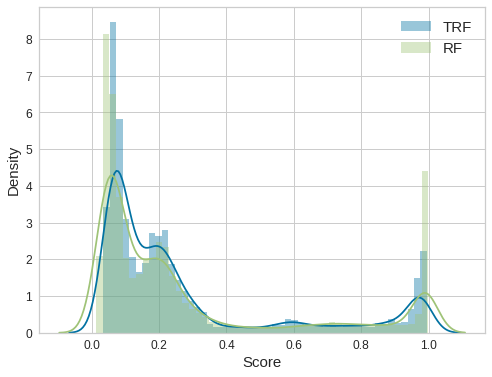

In [92]:
fig, ax = plt.subplots()

sns.distplot(out_of_time["challenger_prediction"], label="TRF")
sns.distplot(out_of_time["benchmark_prediction"], label="RF")

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("Density", fontsize=15)
plt.xlabel("Score", fontsize=15)

__file__ = "../images/{}_trf_rf_score_distribution".format(PREFIX)
plt.savefig(__file__+".jpg", quality=95)
for c in ax.findobj(p):
    c.set_zorder(-1)
    c.set_rasterized(True)
ax.set_rasterization_zorder(0)

ax.set_rasterized(True)
plt.savefig(__file__+".eps")        

plt.savefig("../images/{}_trf_rf_score_distribution.eps".format(PREFIX), format="eps")
plt.show()

In [93]:
ss = StandardScaler()
out_of_time["challenger_prediction_norm"] = ss.fit_transform(out_of_time[["challenger_prediction"]])
out_of_time["benchmark_prediction_norm"] = ss.fit_transform(out_of_time[["benchmark_prediction"]])

<AxesSubplot:xlabel='benchmark_prediction_norm', ylabel='Density'>

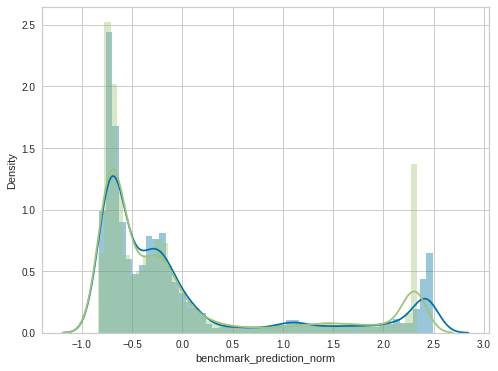

In [94]:
sns.distplot(out_of_time["challenger_prediction_norm"])
sns.distplot(out_of_time["benchmark_prediction_norm"])

In [95]:
X_train, X_test, y_train, y_test = train_test_split(out_of_time[features], 
                                                    out_of_time[["challenger_prediction", 
                                                                 "benchmark_prediction"]],
                                                    test_size=0.6,
                                                    random_state=42)

print(X_train.shape)
print(X_test.shape)

(18018, 13)
(27027, 13)


In [96]:
numerical_features = [feature for feature in features if feature not in columns_to_label_encode]
numerical_features

['Latitude', 'Longitude', 'Beat', 'District', 'Ward', 'Community Area']

In [97]:
p99 = X_train[numerical_features].quantile(.99)
p01 = X_train[numerical_features].quantile(.01)
p005 = X_train.quantile(.005)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] < p99, other=p99, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] < p99, other=p99, axis=1)

X_train[numerical_features] = X_train[numerical_features].where(
    X_train[numerical_features] > p01, other=p01, axis=1)
X_test[numerical_features] = X_test[numerical_features].where(
    X_test[numerical_features] > p01, other=p01, axis=1)

X_train = X_train.fillna(p005)
X_test = X_test.fillna(p005)

In [98]:
dtype = ["numerical" if feature not in columns_to_label_encode else "categorical" for feature in features]

gam_challenger = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["challenger_prediction"].values)
gam_benchmark = LinearGAM(dtype=dtype).gridsearch(X_train[features].values, y_train["benchmark_prediction"].values)

100% (11 of 11) |########################| Elapsed Time: 0:00:16 Time:  0:00:16
100% (11 of 11) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


In [99]:
# pred_test = gam_challenger.predict(X_test[features])
# print("r2 test (challenger): %f" %r2_score(y_test["challenger_prediction"], pred_test))

# pred_test = gam_benchmark.predict(X_test[features])
# print("r2 test (benchmark): %f" %r2_score(y_test["benchmark_prediction"], pred_test))

In [100]:
X_test.describe()

,Primary Type,Description,Location Description,FBI Code,Zone,Address,Latitude,Longitude,Beat,District,Ward,Community Area,Domestic
count,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000,27027.000000
mean,13.998742,174.741999,86.357235,11.945240,2.970141,1230.775447,40.895969,-87.670909,1156.875310,11.231657,22.814482,37.709957,0.148481
std,10.932487,97.999103,35.175355,6.520735,0.884194,617.747353,6.292124,0.057410,693.430644,6.892845,13.774983,21.507785,0.355583
min,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,-1.000000,-87.810698,113.000000,1.000000,1.000000,1.000000,0.000000
25%,3.000000,113.000000,72.000000,7.000000,2.000000,715.000000,41.764443,-87.713392,613.000000,6.000000,10.000000,23.000000,0.000000
50%,15.000000,212.000000,99.000000,10.000000,3.000000,1240.000000,41.851921,-87.666392,1024.000000,10.000000,22.000000,32.000000,0.000000
75%,26.000000,266.000000,113.000000,16.000000,4.000000,1783.000000,41.903544,-87.628512,1712.000000,17.000000,34.000000,58.000000,0.000000
max,30.000000,318.000000,126.000000,25.000000,4.000000,2233.000000,42.012594,-87.549176,2534.000000,25.000000,49.000000,76.000000,1.000000


In [101]:
import matplotlib as mpl 
mpl.rcParams['agg.path.chunksize'] = 10000

Latitude
6


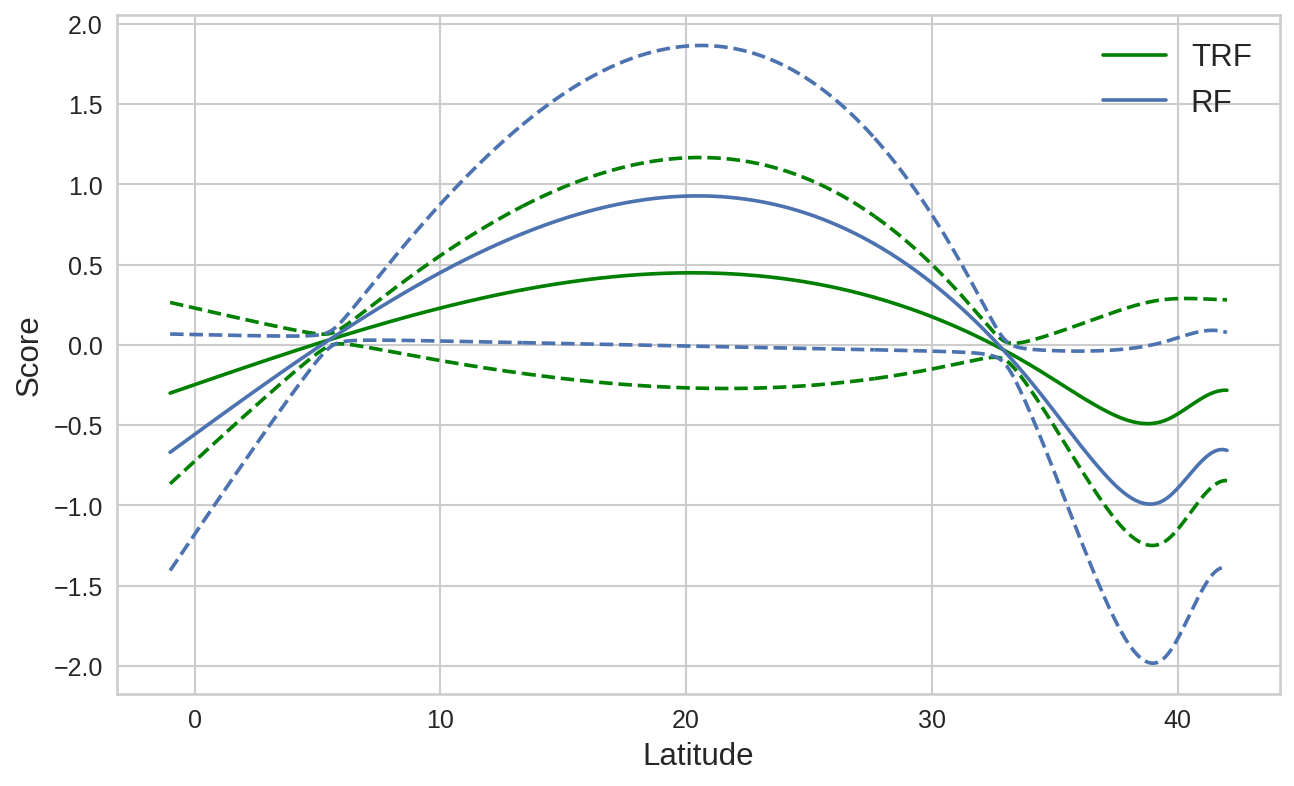

Longitude
7


<Figure size 576x432 with 0 Axes>

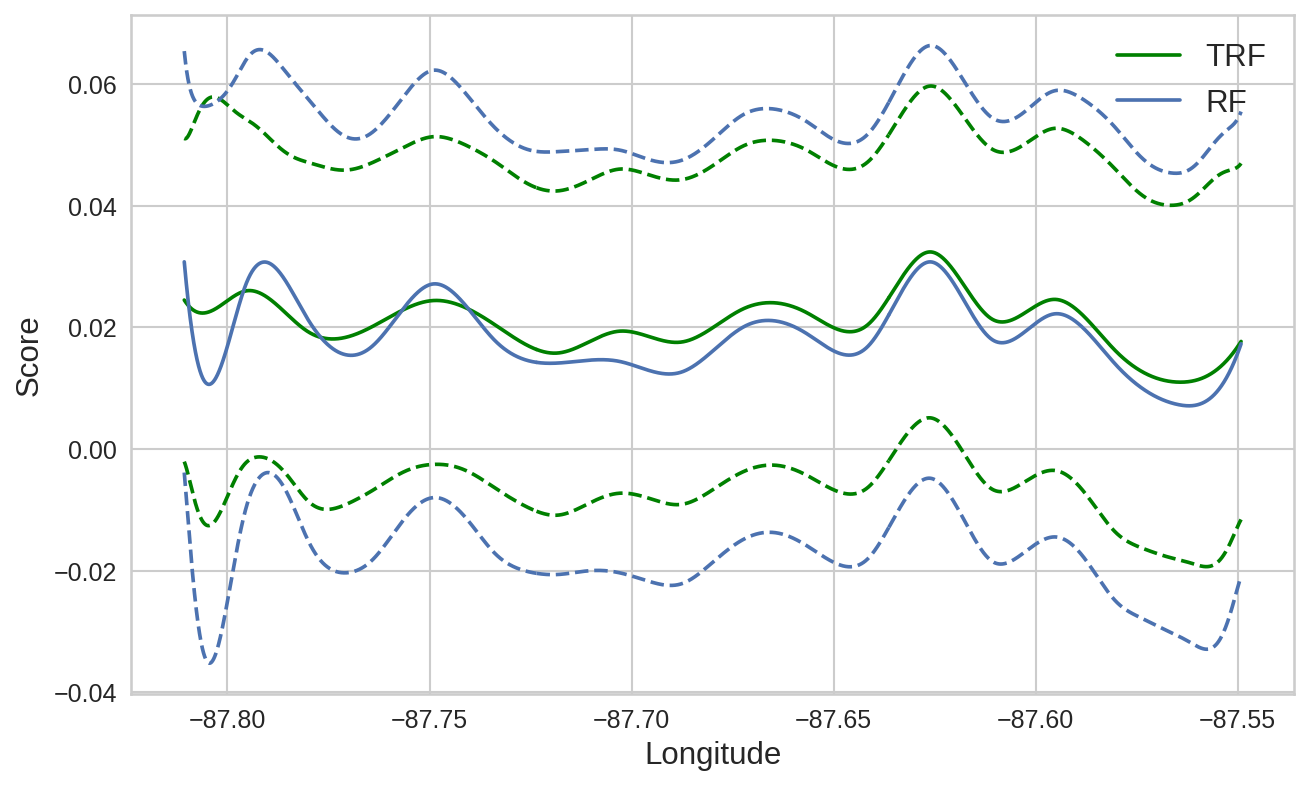

Beat
8


<Figure size 576x432 with 0 Axes>

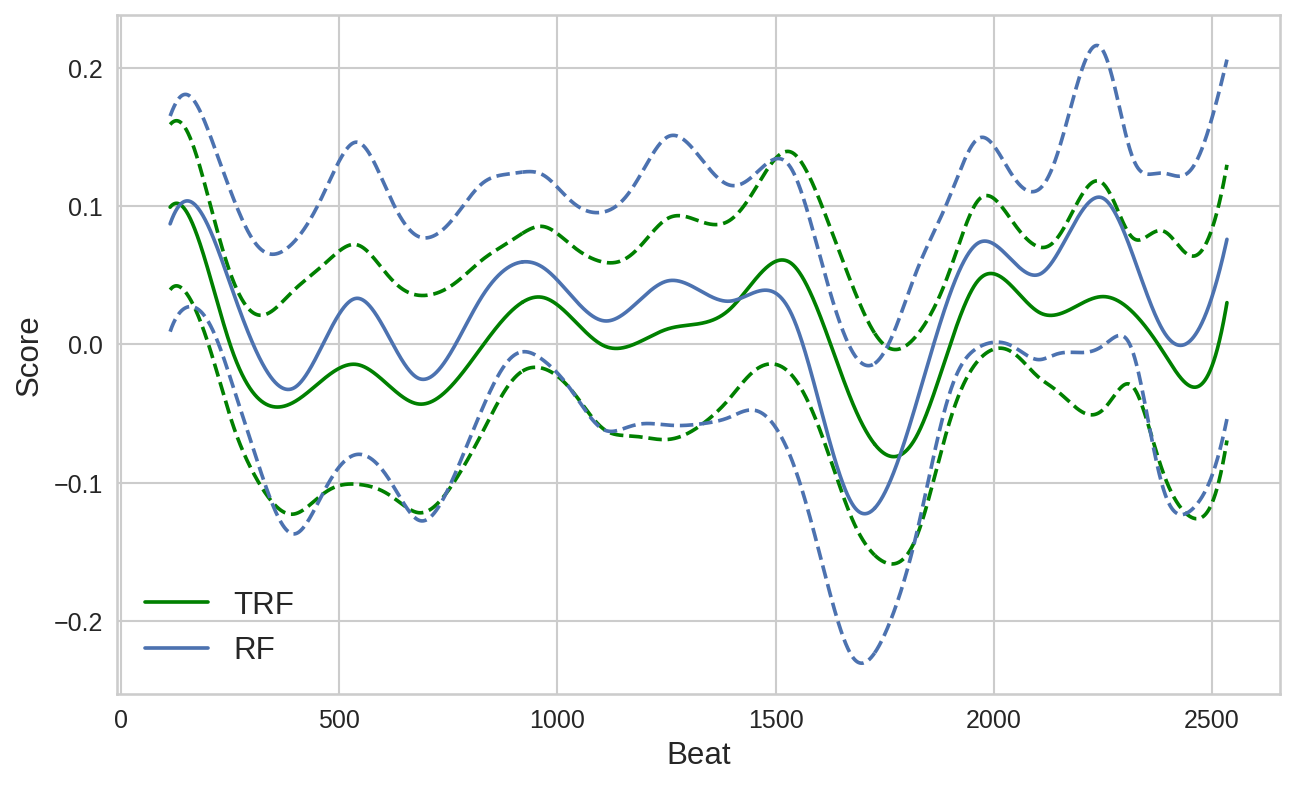

District
9


<Figure size 576x432 with 0 Axes>

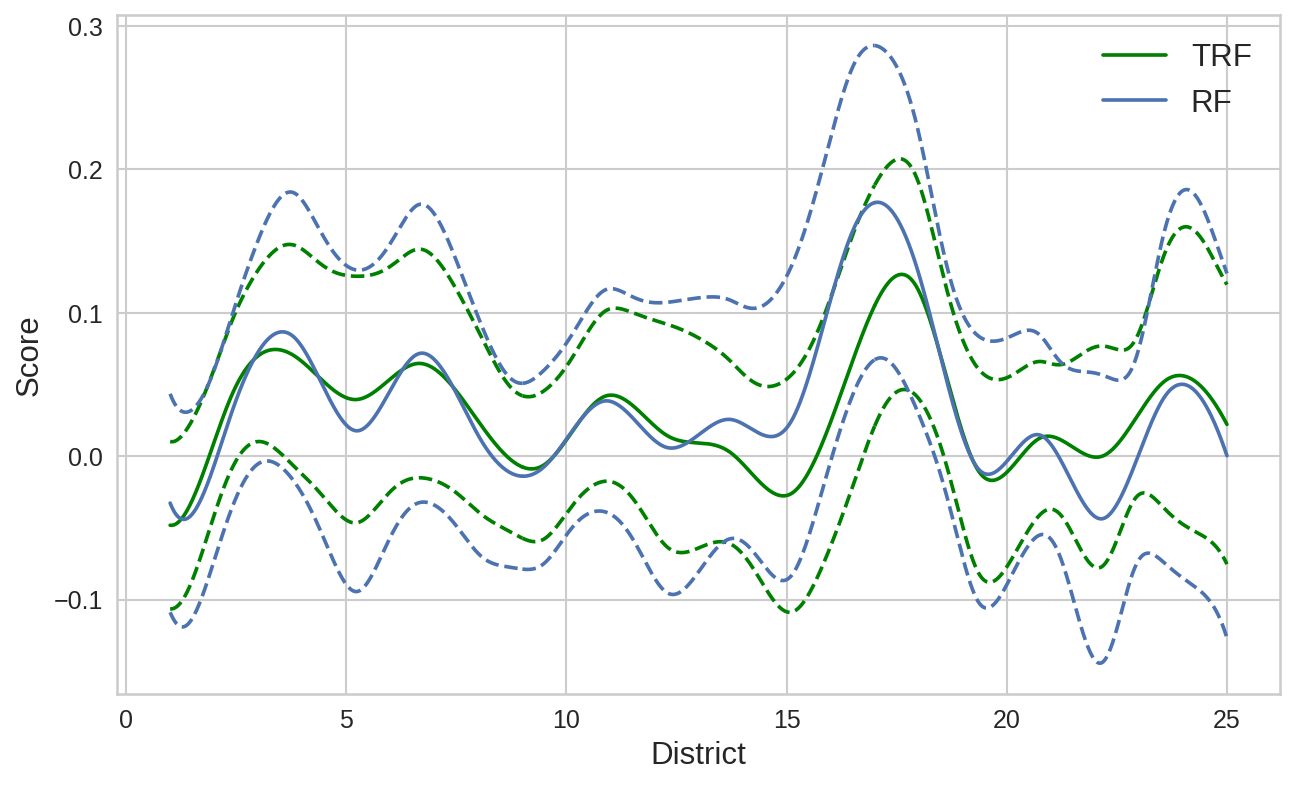

Ward
10


<Figure size 576x432 with 0 Axes>

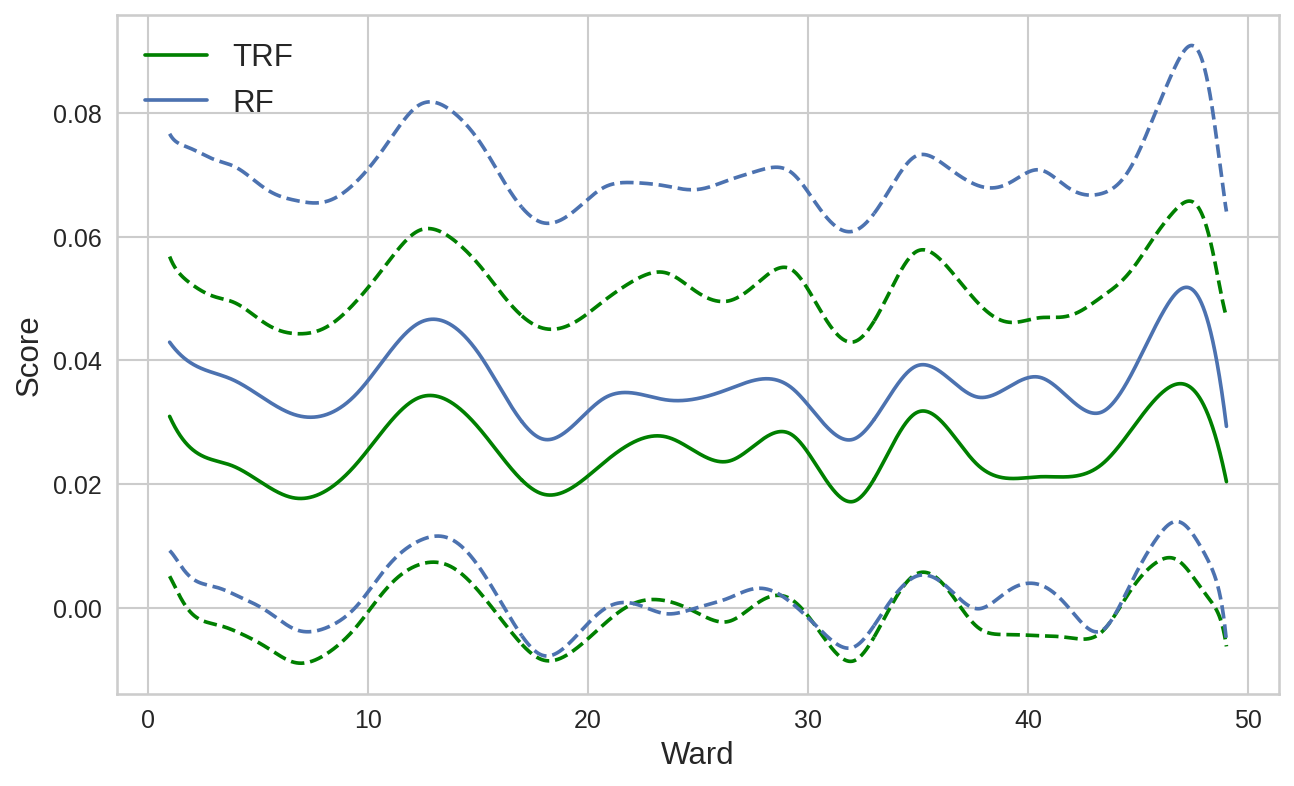

Community Area
11


<Figure size 576x432 with 0 Axes>

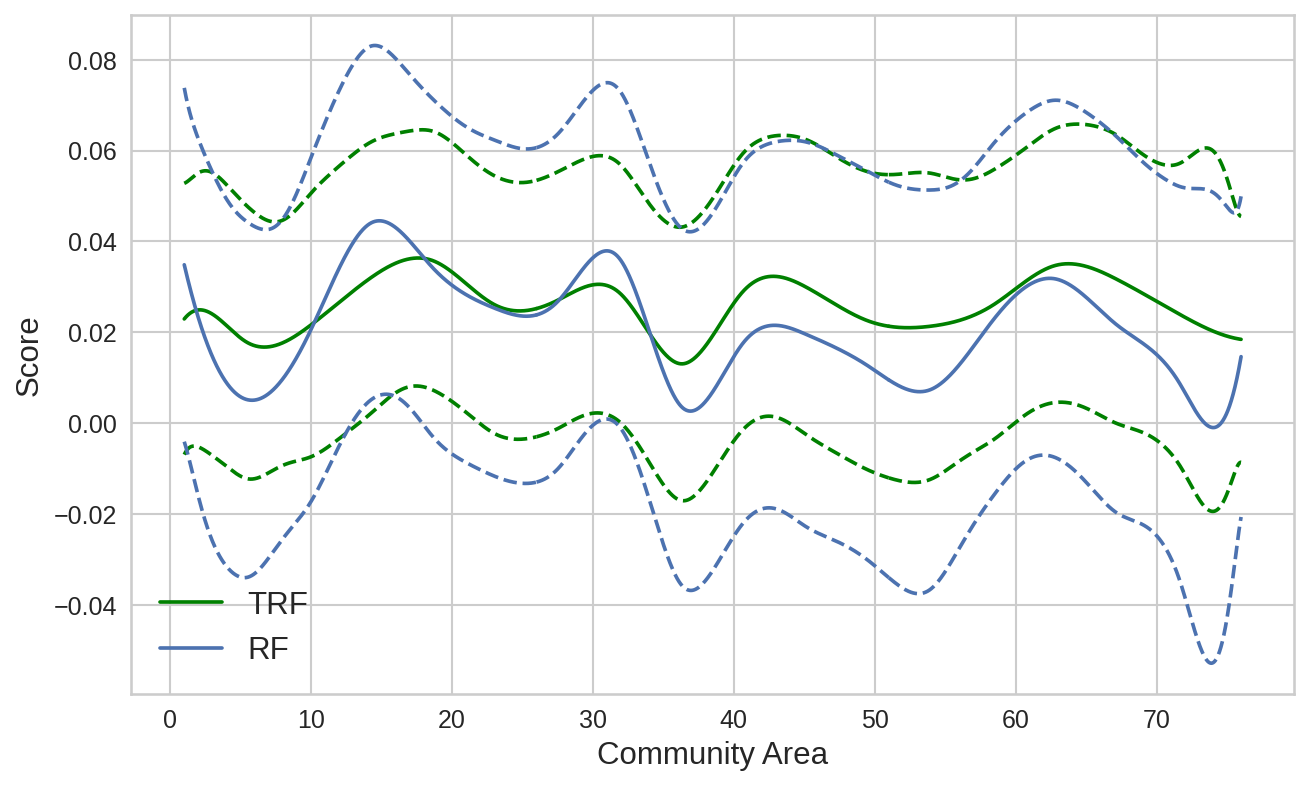

<Figure size 576x432 with 0 Axes>

In [105]:
for i, feat in enumerate(features):
    if feat not in numerical_features:
        continue
    print(feat)
    print(i)
    XX = gam_challenger.generate_X_grid(i, n=X_test.shape[0])
    ### Fix needed for this dataset
    XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
    XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2233, 2232, X_test.values[:, 5].astype(int))
    pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

    plt.plot(XX[:, i], pdep, c="green", label="TRF")
    plt.plot(XX[:, i], confi, c='green', ls='--')
    plt.ylabel("Score")
    plt.legend()

    ### Benchmark
    pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
    plt.plot(XX[:, i], pdep, color="#4c72b0", label="RF")
    plt.plot(XX[:, i], confi, c='#4c72b0', ls='--')
    plt.ylabel("Score", fontsize=15)
    plt.legend()

    plt.xlabel(feat, fontsize=15)

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    xmin, xmax, ymin, ymax = plt.axis()
    plt.ylim([ymin, ymax])
    plt.legend(fontsize=15)
    plt.savefig("../images/{}_feature_impact_{}.eps".format(PREFIX, feat), format="eps")

    plt.show()
    plt.clf()

Primary Type


No handles with labels found to put in legend.


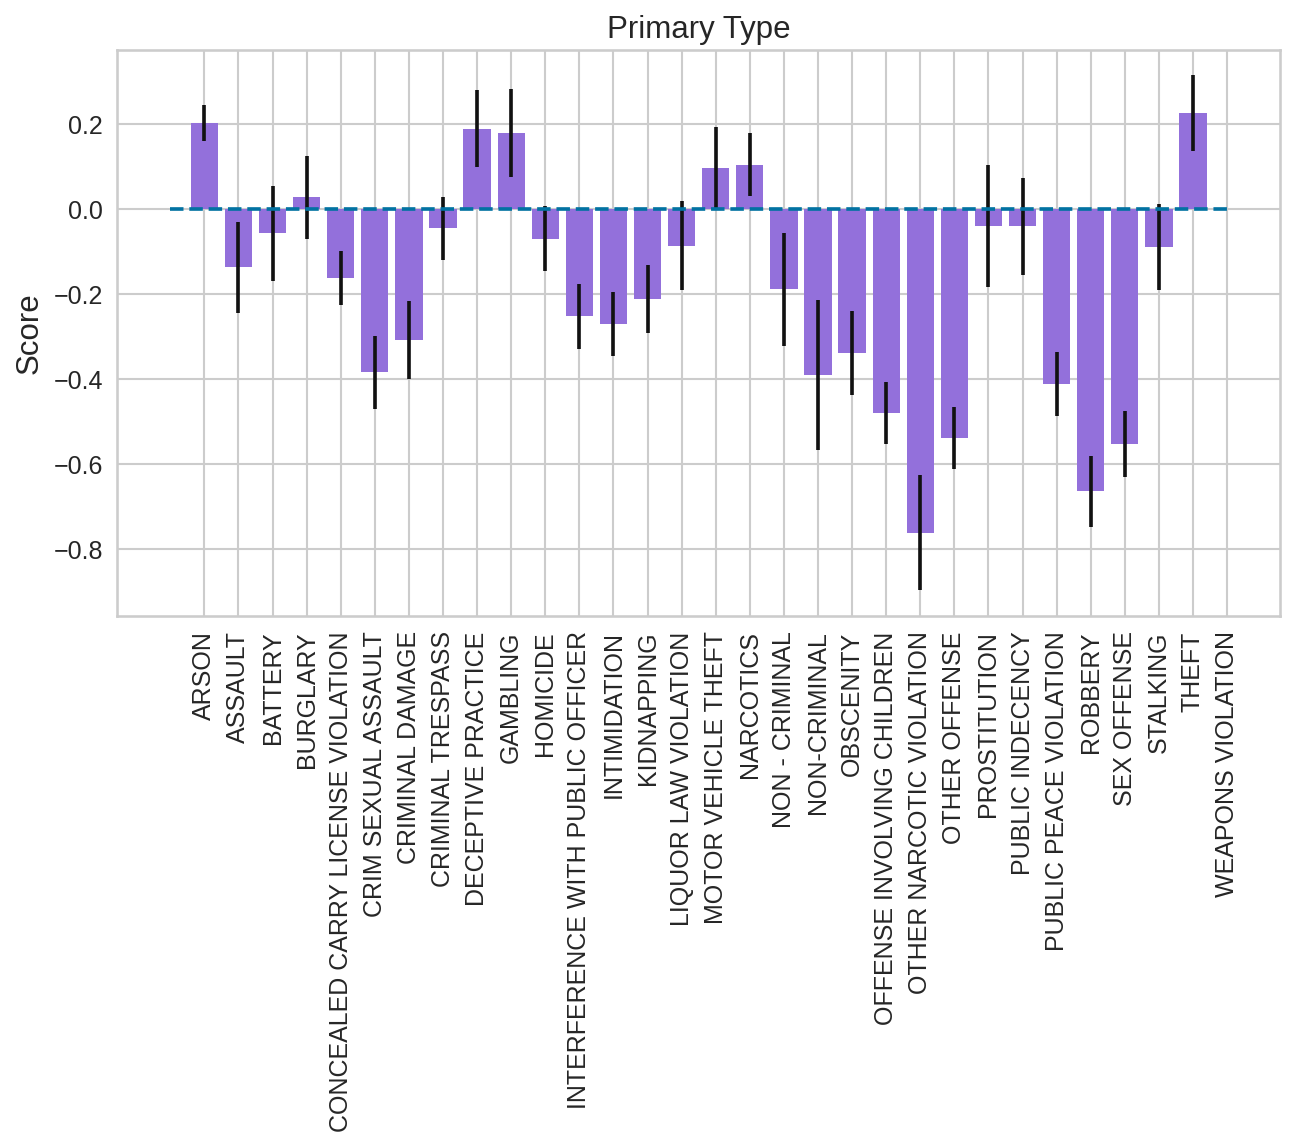

No handles with labels found to put in legend.


Description
Location Description
FBI Code


<Figure size 576x432 with 0 Axes>

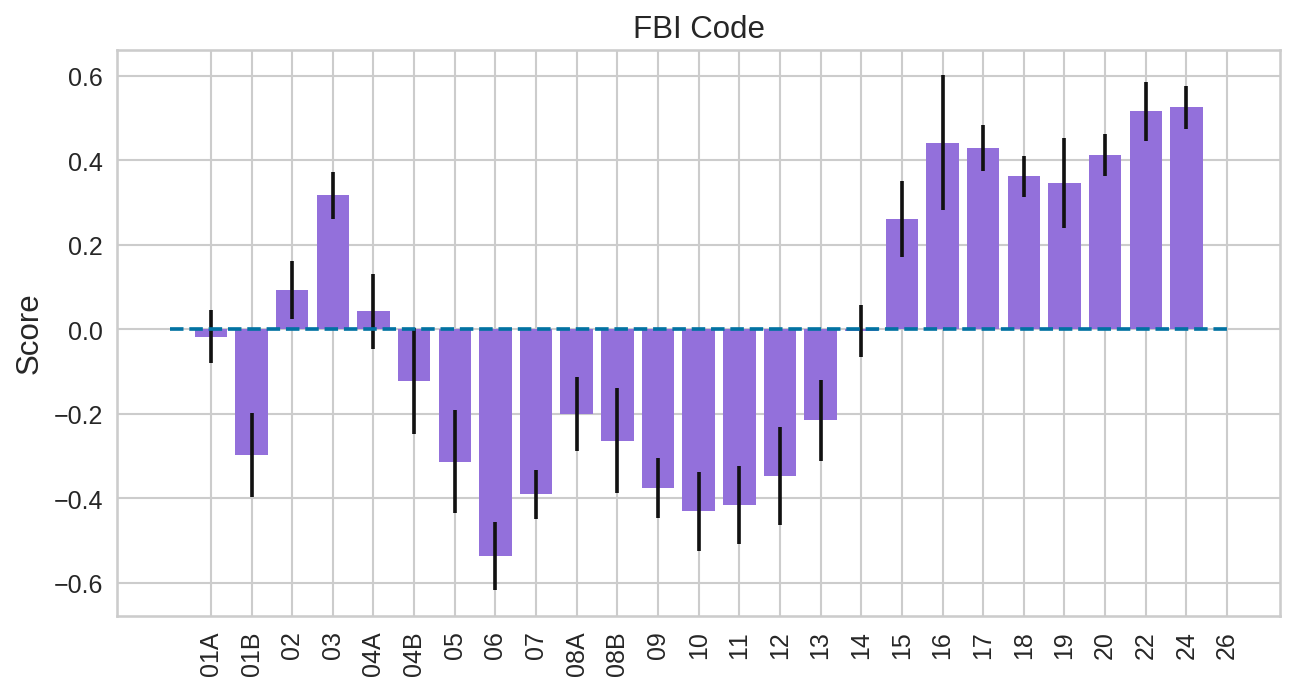

No handles with labels found to put in legend.


Zone


<Figure size 576x432 with 0 Axes>

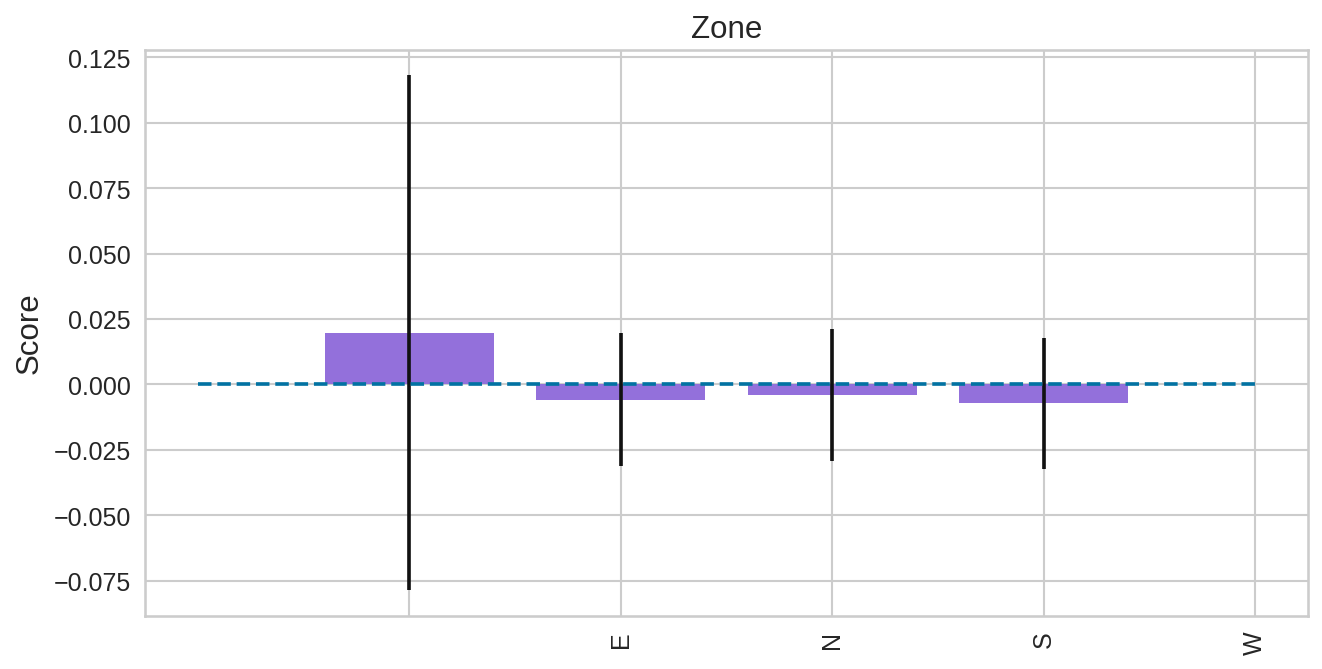

No handles with labels found to put in legend.


Address
Domestic


<Figure size 576x432 with 0 Axes>

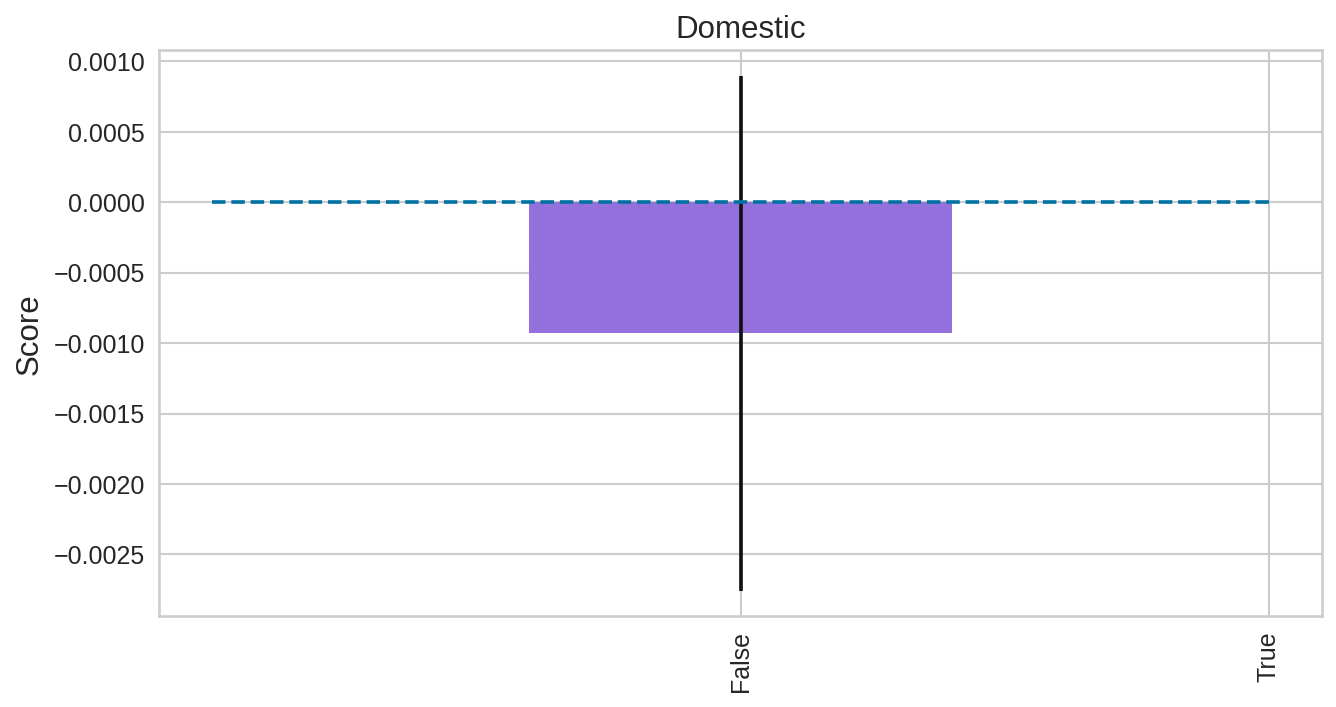

<Figure size 576x432 with 0 Axes>

In [107]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        #try:
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
        XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2233, 2232, X_test.values[:, 5].astype(int))
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        agg = data.groupby(feat).mean()

        impact_plot = plt.bar([i for i in range(len(agg))],
                              agg["Mean Impact"],
                              yerr=agg[["low", "high"]].values.transpose(),
                              color="#9370DB",
                              capsize=7)

        plt.title(feat, fontsize=15)
        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)

        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_{}.eps".format(PREFIX, feat), format="eps")

        plt.show()
        plt.clf()
#         except:
#             print("No plot for {}".format(feat))
plt.show()

Primary Type


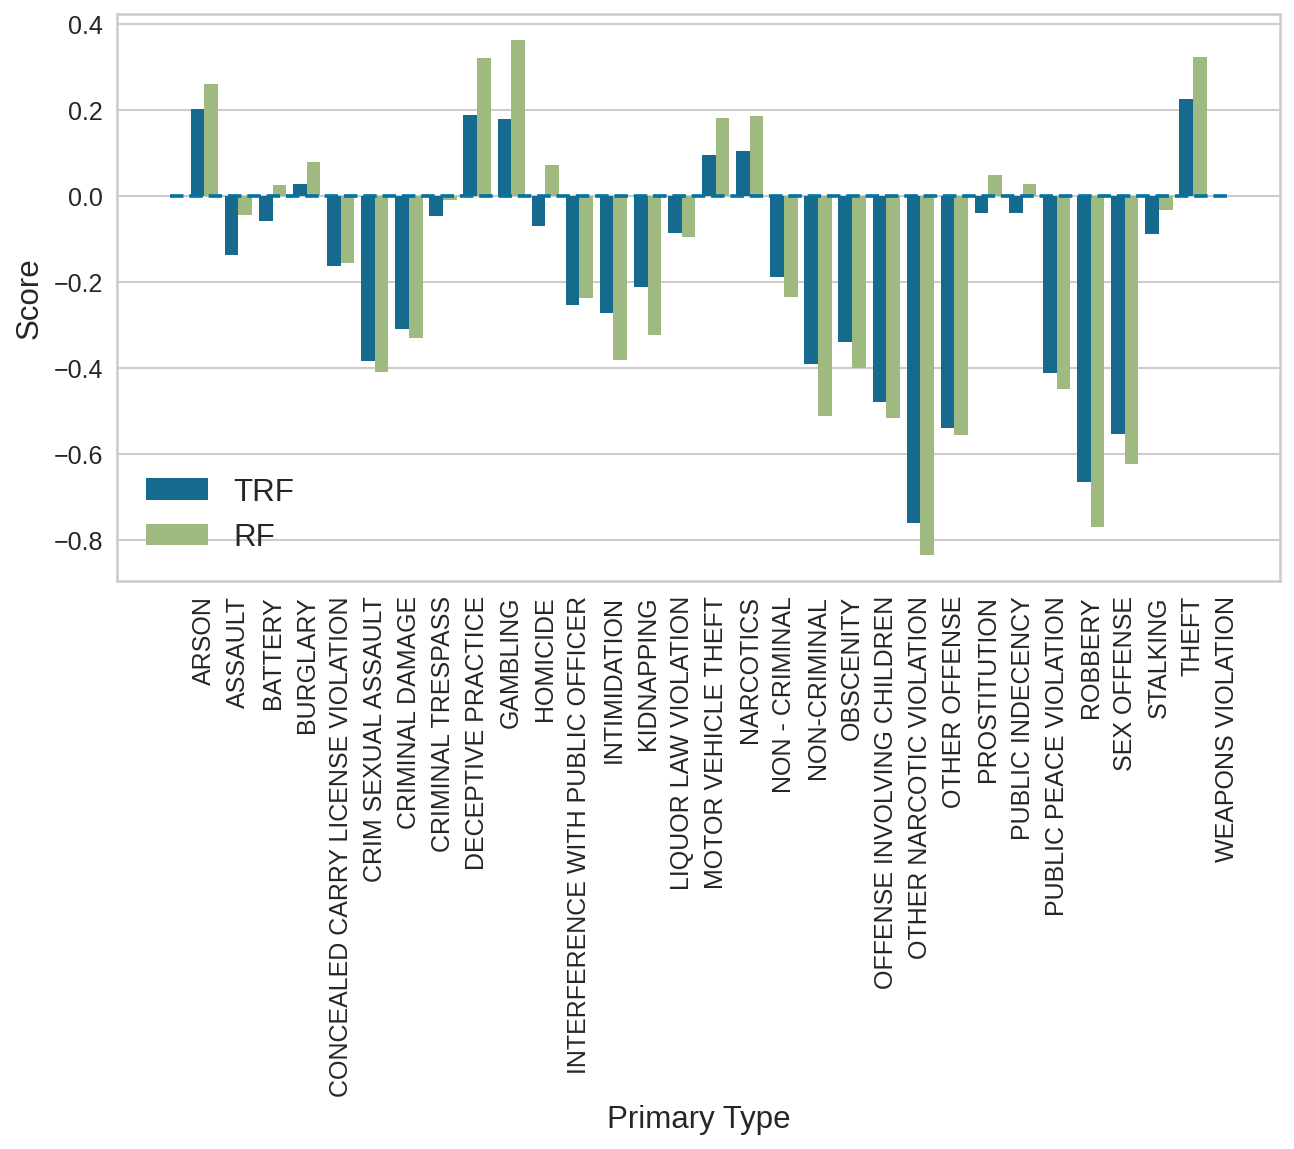

Description
Location Description
FBI Code


<Figure size 576x432 with 0 Axes>

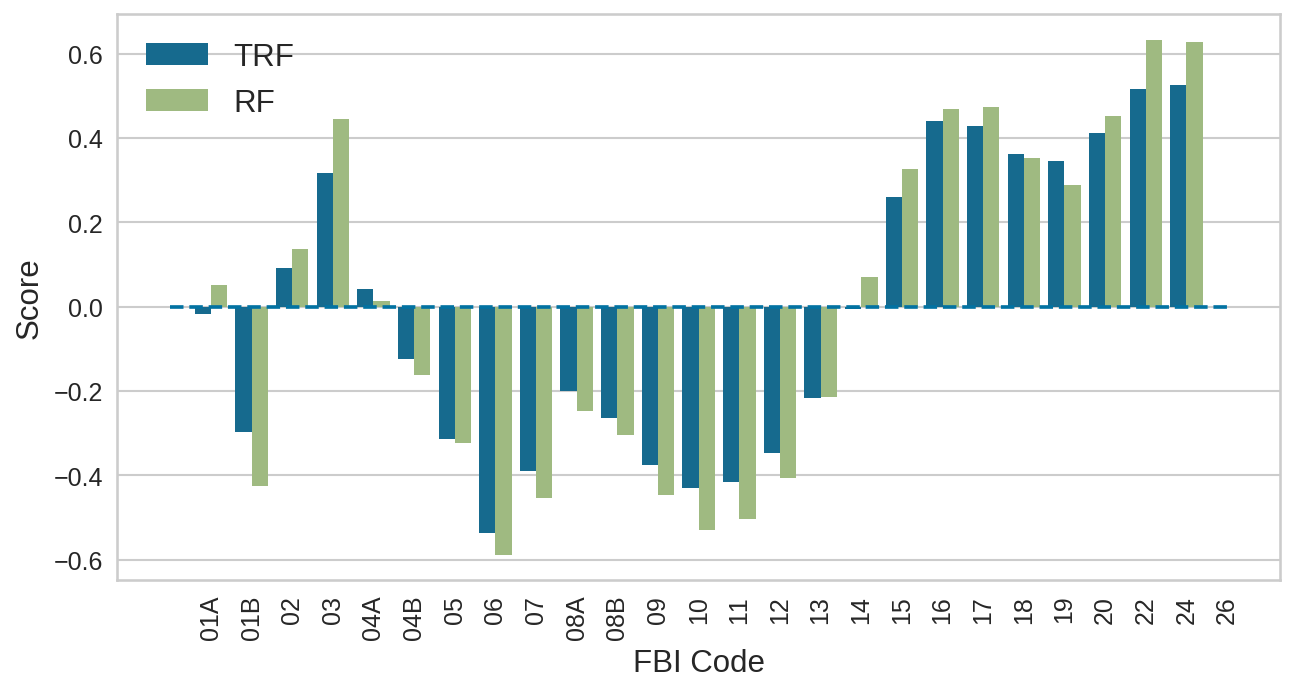

Zone


<Figure size 576x432 with 0 Axes>

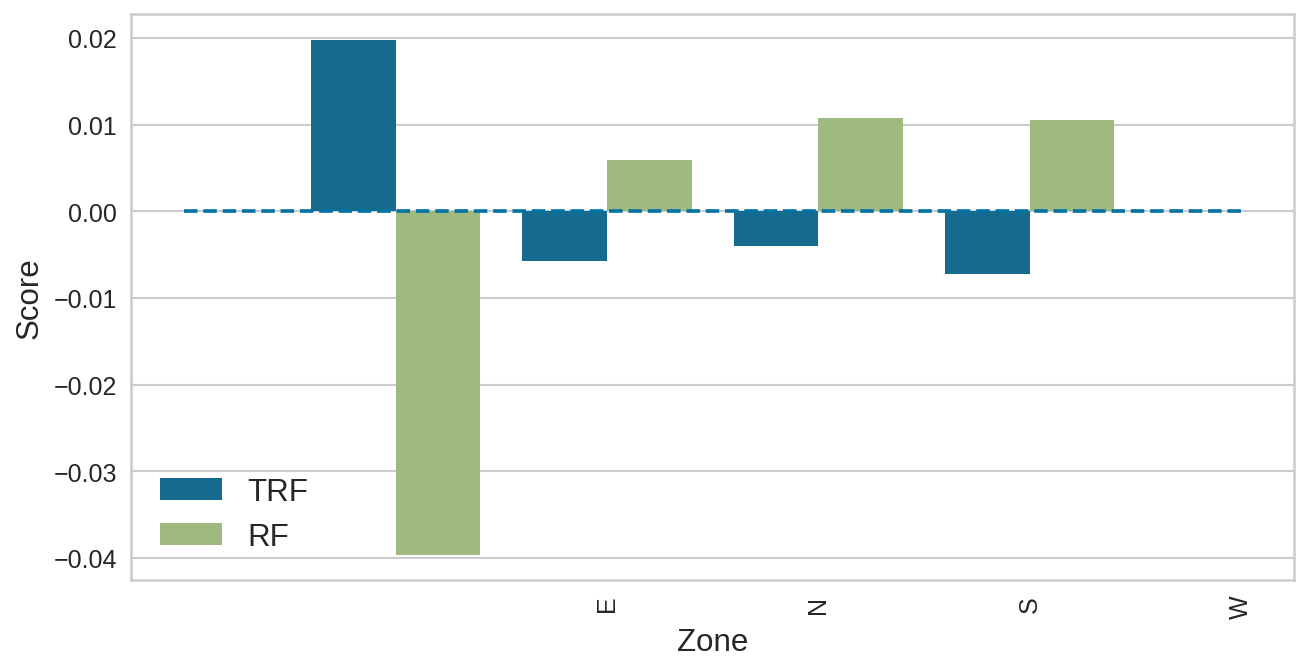

Address
Domestic


<Figure size 576x432 with 0 Axes>

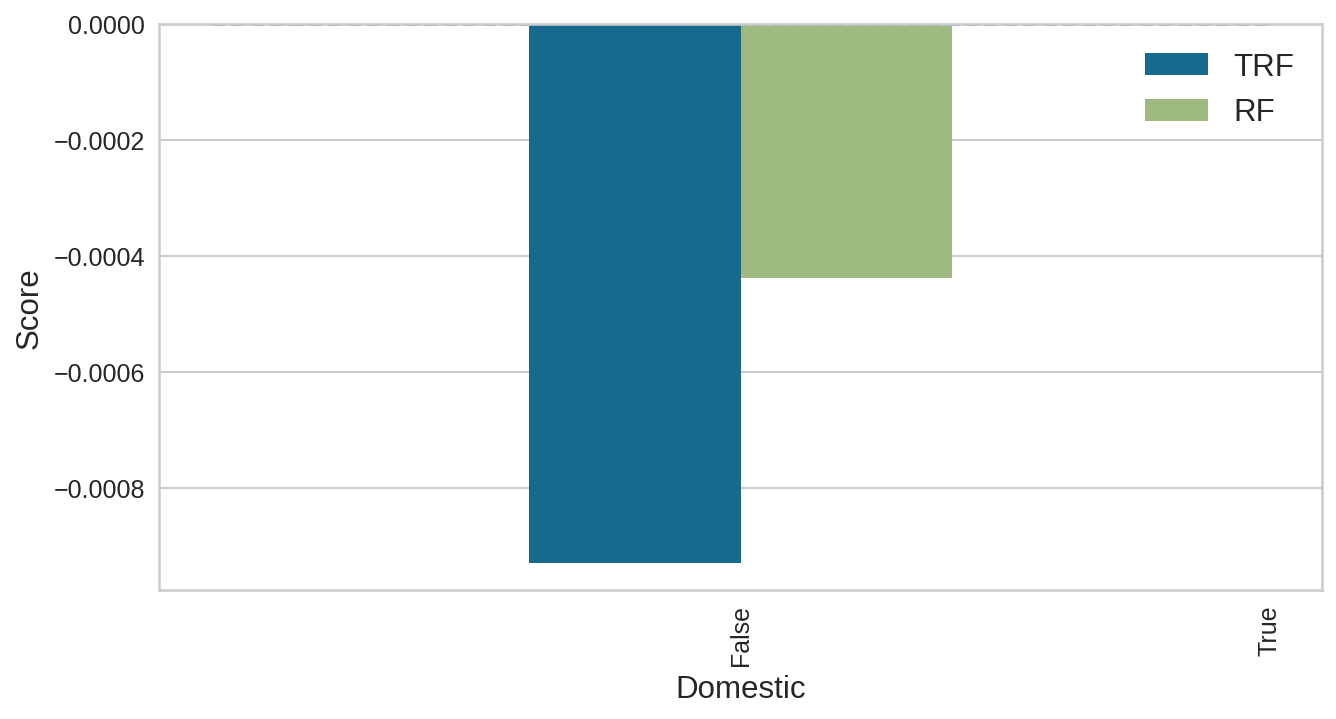

<Figure size 576x432 with 0 Axes>

In [109]:
for i, feat in enumerate(features):
    if feat in columns_to_label_encode:
        print(feat)
        mapping = encoder_mappings[feat]
        max_cat = np.max(list(mapping.keys()))
        if max_cat > 100:
            continue
        XX = np.copy(X_test)
        XX[:, i] = np.random.randint(0, max_cat, size=X_test.shape[0])
        XX[:, 1] = np.where(X_test.values[:, 1].astype(int) >= 329, 328, X_test.values[:, 1].astype(int))
        XX[:, 5] = np.where(X_test.values[:, 5].astype(int) >= 2233, 2232, X_test.values[:, 5].astype(int))

        ### Challenger
        pdep, confi = gam_challenger.partial_dependence(i, X=XX, width=.95)
        fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
        data = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data["low"] = np.abs(data["low"] - data["Mean Impact"])
        data["high"] = np.abs(data["high"] - data["Mean Impact"])
        data["model"] = "TRF"
        agg = data.groupby(feat).mean()


        ### Benchmark
        pdep, confi = gam_benchmark.partial_dependence(i, X=XX, width=.95)
        data_benchmark = pd.DataFrame(np.hstack([XX[:, i].reshape(-1, 1), pdep.reshape(-1, 1), confi]),
                            columns=[feat, "Mean Impact", "low", "high"])
        data_benchmark["low"] = np.abs(data_benchmark["low"] - data_benchmark["Mean Impact"])
        data_benchmark["high"] = np.abs(data_benchmark["high"] - data_benchmark["Mean Impact"])
        data_benchmark["model"] = "RF"
        
        data = pd.concat([data, data_benchmark])
        agg = data.groupby(feat).mean()
        
        sns.barplot(data=data, x=feat, y="Mean Impact", hue="model")


        plt.xticks([i for i in range(len(list(mapping.keys())))])
        ax.set_xticklabels(list(mapping.values()), rotation=90)
        plt.hlines(0.0, -1, max_cat, linestyles="dashed")
        plt.ylabel("Score", fontsize=15)
        
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)
        xmin, xmax, ymin, ymax = plt.axis()
        plt.ylim([ymin, ymax])
        plt.legend(fontsize=15)
        plt.xlabel(feat, fontsize=15)
        plt.savefig("../images/{}_feature_impact_cat_comparison_{}.eps".format(PREFIX, feat), format="eps")
        
        plt.show()
        plt.clf()

## Minimum samples by period effect

In [112]:
target = TARGET
min_sample_periods_values = [1, 5, 10, 20, 50, 100, 250, 500]

In [ ]:
min_sample_knob = {}
min_sample_knob["challenger"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}
unseen_performance = []
train_performance = []
test_performance = []
unseen_performance_by_period = []

challenger_params = challenger_opt_param.copy()
challenger_params.pop("min_sample_periods")
for min_sample_periods in min_sample_periods_values:
    model_split_time = TimeForestClassifier(time_column=TIME_COLUMN,
                                        min_sample_periods=min_sample_periods,
                                        multi=True,
                                        **challenger_params)
    
    model_split_time.fit(train[features + [TIME_COLUMN]], train[target])
    out_of_time["time_split_prediction"] = model_split_time.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["challenger"]["unseen_performance"].append(performance)
    min_sample_knob["challenger"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model_split_time.predict(train[features])
    min_sample_knob["challenger"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model_split_time.predict(test[features])
    min_sample_knob["challenger"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

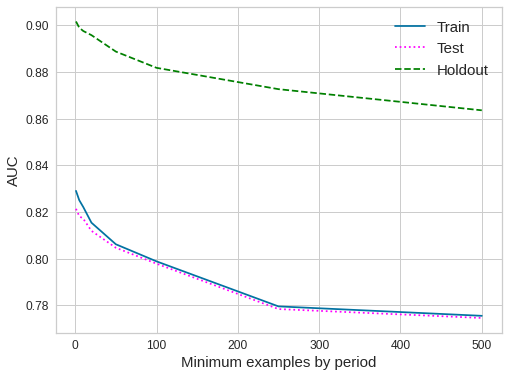

In [141]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="Train")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="Test", 
         color="magenta",
         linestyle="dotted")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole.eps".format(PREFIX), format="eps")
plt.show()

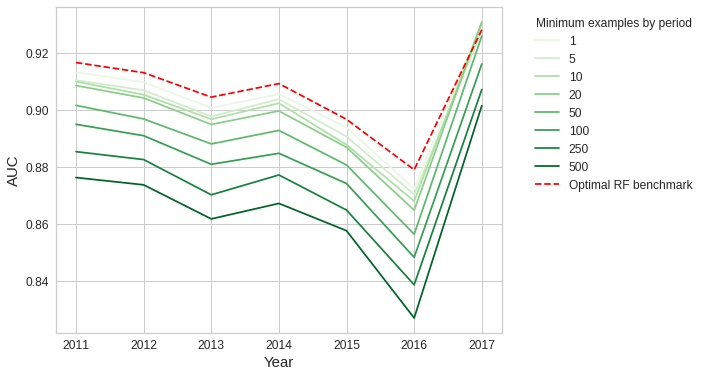

In [142]:
fig, ax = plt.subplots()

greens = plt.get_cmap("Greens")
gradient = np.linspace(.1, 0.9, len(min_sample_periods_values))
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

In [ ]:
min_sample_knob["benchmark"] = {"unseen_performance": [], "train_performance": [],
                                "test_performance": [], "unseen_performance_by_period": []}

bench_params = benchmark_opt_param.copy()
bench_params.pop("min_sample_periods")

training_segments = train[TIME_COLUMN].nunique()
for min_sample_periods in min_sample_periods_values:

    model = TimeForestClassifier(time_column=DUMMY_TIME_COLUMN,
                                       multi=True, 
                                       min_sample_periods=training_segments * min_sample_periods,
                                       **bench_params)
    
    
    model.fit(train[features + [DUMMY_TIME_COLUMN]],
              train[TARGET])
     
    out_of_time["time_split_prediction"] = model.predict_proba(out_of_time[features])[:, 1]
    
    performance = metrics.roc_auc_score(out_of_time[target], out_of_time["time_split_prediction"])
    min_sample_knob["benchmark"]["unseen_performance"].append(performance)
    min_sample_knob["benchmark"]["unseen_performance_by_period"].append(out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["time_split_prediction"])))

    train["time_split_prediction"] = model.predict(train[features])
    min_sample_knob["benchmark"]["train_performance"].append(metrics.roc_auc_score(train[target], train["time_split_prediction"]))
    
    test["time_split_prediction"] = model.predict(test[features])
    min_sample_knob["benchmark"]["test_performance"].append(metrics.roc_auc_score(test[target], test["time_split_prediction"]))

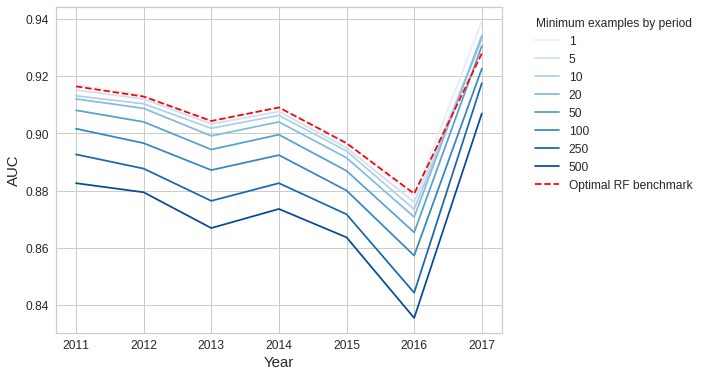

In [150]:
fig, ax = plt.subplots()

blues = plt.get_cmap("Blues")
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))

out_of_time.groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[target], x["benchmark_prediction"])).plot(label="Optimal RF benchmark", 
                                                                                                 color="red", linestyle="dashed", ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

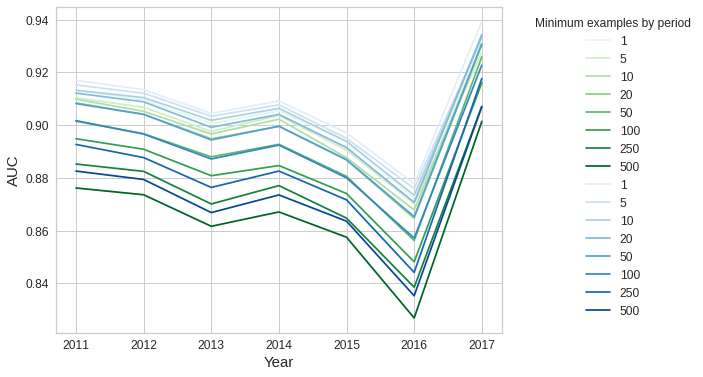

In [151]:
fig, ax = plt.subplots()
for i, experiment in enumerate(min_sample_knob["challenger"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=greens(gradient[i]))
    
for i, experiment in enumerate(min_sample_knob["benchmark"]["unseen_performance_by_period"]):
    experiment.plot(label=min_sample_periods_values[i], color=blues(gradient[i]))    

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(bbox_to_anchor=(1.05, 1.0), fontsize=12, title="Minimum examples by period")
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)

x_labels = np.sort(out_of_time[TIME_COLUMN].unique())
plt.xticks(x_labels)

plt.savefig("../images/{}_holdout_dif_min_samples_benchmark_challenger.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()

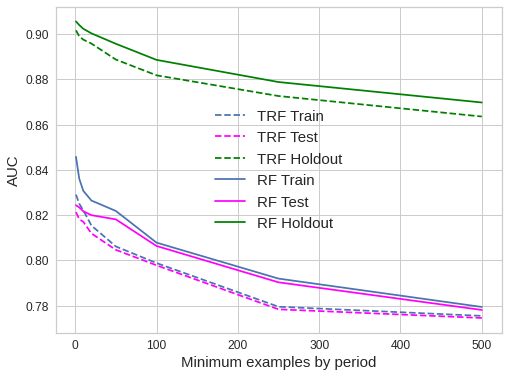

In [152]:
fig, ax = plt.subplots()
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["train_performance"], label="TRF Train",
        color="#4c72b0", linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["test_performance"], label="TRF Test", 
         color="magenta",
         linestyle="dashed")
plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["train_performance"], label="RF Train",
        color="#4c72b0")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["test_performance"], label="RF Test", 
         color="magenta")
plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_test_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

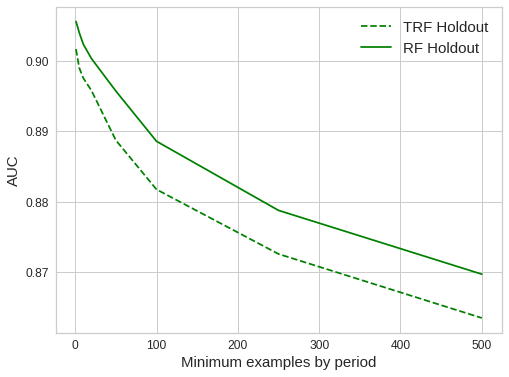

In [153]:
fig, ax = plt.subplots()

plt.plot(min_sample_periods_values, min_sample_knob["challenger"]["unseen_performance"], label="TRF Holdout", 
                                                         linestyle="dashed",
                                                         color="green")

plt.plot(min_sample_periods_values, min_sample_knob["benchmark"]["unseen_performance"], label="RF Holdout", 
                                                         color="green")

#plt.title("Holdout AUC by minimum examples by period parameter", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
xmin, xmax, ymin, ymax = plt.axis()
plt.ylim([ymin, ymax])
plt.legend(fontsize=15)
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Minimum examples by period", fontsize=15)
plt.savefig("../images/{}_holdout_min_example_by_period_train_and_holdout_whole_bench_challenger.eps".format(PREFIX), format="eps")
plt.show()

## Domain classifier

In [273]:
train["domain"] = 1
test["domain"] = 1
out_of_time["domain"] = 0

In [274]:
domain_data = pd.concat([train, test, out_of_time])

In [275]:
train_domain, test_domain = train_test_split(domain_data, 
                               test_size=0.2,
                               random_state=42)

In [276]:
clf2 = setup(train_domain[features + ["domain"]], target="domain",
             session_id=124, 
             log_experiment=False, 
             experiment_name="{}_domain".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_domain_rf = tune_model(rf,
                             optimize="AUC",
                             fold=5,
                             n_iter=50)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9485,0.9882,0.9381,0.9107,0.9242,0.8853,0.8855
1,0.9431,0.9880,0.9377,0.8969,0.9169,0.8737,0.8742
2,0.9460,0.9880,0.9393,0.9032,0.9209,0.8800,0.8804
3,0.9436,0.9881,0.9309,0.9033,0.9169,0.8742,0.8744
4,0.9426,0.9877,0.9398,0.8941,0.9164,0.8728,0.8734
Mean,0.9448,0.9880,0.9372,0.9017,0.9191,0.8772,0.8776
SD,0.0022,0.0002,0.0032,0.0058,0.0031,0.0048,0.0047


INFO:logs:create_model_container: 2
INFO:logs:master_model_container: 2
INFO:logs:display_container: 3
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=11, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0005, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=-1, oob_score=False, random_state=124, verbose=0,
                       warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [277]:
domain_model = tuned_domain_rf

In [278]:
domain_model.fit(train_domain[features], train_domain["domain"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=11, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0005, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=120,
                       n_jobs=-1, oob_score=False, random_state=124, verbose=0,
                       warm_start=False)

In [279]:
test_domain["pred_domain"] = domain_model.predict_proba(test_domain[features])[:, 1]

In [280]:
roc_auc_score(test_domain["domain"], test_domain["pred_domain"])

0.9872778761144587

## Other optimization design for the RF

In [ ]:
last_time_segment_in_train = np.max(in_time[TIME_COLUMN].unique())
last_time_segment_in_train

In [ ]:
posfix = str(last_time_segment_in_train)

In [ ]:
new_train = in_time[in_time["Year"] < last_time_segment_in_train]
new_validation = in_time[in_time["Year"] == last_time_segment_in_train]

In [ ]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=44,
             log_experiment=False,
             experiment_name="{}_opt1".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                      optimize="AUC",
                      n_iter=25)

In [ ]:
tuned_rf

In [ ]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

In [ ]:
new_validation, add_to_train = train_test_split(new_validation, test_size=0.5)

new_train = pd.concat([new_train, add_to_train])

In [ ]:
clf1 = setup(new_train[features + [TARGET]], target=TARGET,
             test_data=new_validation,
             session_id=22,
             log_experiment=False,
             experiment_name="{}_opt2".format(PREFIX),
             silent=True)

rf = create_model('rf')
tuned_rf = tune_model(rf,
                     optimize="AUC",
                     n_iter=50)

In [ ]:
benchmark_model = tuned_rf
benchmark_model.fit(train[features], train[TARGET])

train["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(train[features])[:, 1]
test["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(test[features])[:, 1]
out_of_time["benchmark_prediction_opt_half_{}".format(posfix)] = benchmark_model.predict_proba(out_of_time[features])[:, 1]

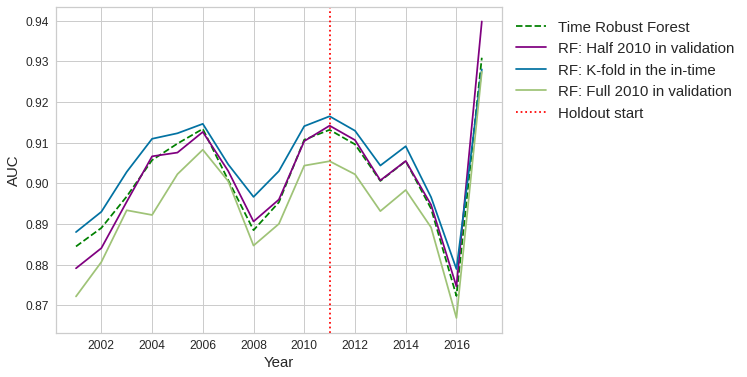

In [139]:
fig, ax = plt.subplots()
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["challenger_prediction"])).plot(label="Time Robust Forest", 
                                                                                                      linestyle="dashed",
                                                                                                      color="green", ax=ax)

pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_half_{}".format(posfix)])).plot(label="RF: Half {} in validation".format(posfix), 
                                                                                                      #linestyle="dashed",
                                                                                                      color="purple", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction"])).plot(label="RF: K-fold in the in-time", ax=ax)
pd.concat([test, out_of_time]).groupby(TIME_COLUMN).apply(lambda x: roc_auc_score(x[TARGET], x["benchmark_prediction_opt_{}".format(posfix)])).plot(label="RF: Full {} in validation".format(posfix), ax=ax)

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)

xmin, xmax, ymin, ymax = plt.axis()
plt.vlines(training_end_year + 1, ymin, ymax, linestyle="dotted", color="red", label="Holdout start")
plt.ylim([ymin, ymax])
plt.legend(fontsize=15, bbox_to_anchor=(1.0, 1.0))
plt.ylabel("AUC", fontsize=15)
plt.xlabel("Year", fontsize=15)
plt.savefig("../images/{}_performance_proof.eps".format(PREFIX), format="eps", bbox_inches = "tight")
plt.show()


In [ ]:
1

# 